## CNN+LSTM Deep Neuralnetwork

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
import datetime
import sklearn
import gc
from keras import backend as K
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.regularizers import l2
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm
import keras
from keras.regularizers import l2
from keras.layers import Conv1D,MaxPooling1D,  LeakyReLU
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, Concatenate, Flatten,concatenate
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model

Using TensorFlow backend.


In [2]:
import pandas as pd
train=pd.read_csv('train_preprocessed1.csv')


In [3]:
train=train.drop(['Unnamed: 0'], axis=1)


### All catogorical features to 1D conv

In [7]:
def cnn_inp(x_train):

    x_train_cnn = x_train[['building_id','meter','dayofweek_x','is_holiday','group_x','site_id','primary_use']]
    x_train_cnn = x_train_cnn.values[:]
    x_train_cnn = x_train_cnn.reshape((x_train_cnn.shape[0],x_train_cnn.shape[-1],1))
    
    return  x_train_cnn

### Numerical features to LSTM

In [2]:
def lstm_inp(x_train):
    x_train_LSTM = x_train[['square_feet','dew_temperature','relative_humidity','feels_like','cloud_coverage','wind_speed']]
    x_train_LSTM = x_train_LSTM.values[:]
    x_train_LSTM= x_train_LSTM.reshape((x_train_LSTM.shape[0],1,x_train_LSTM.shape[-1]))
    
    return x_train_LSTM

In [3]:
from keras import backend as K
from keras.optimizers import Adam
K.clear_session()

In [4]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Network with CNN and LSTM

In [19]:
def model_dnn(x_train_cnn,x_train_LSTM,y_train,x_cv_cnn,x_cv_LSTM,y_valid,fold_n):
    inp_1 = Input(shape=(7,1), name="cat_features")
    conv1 = Conv1D(512,2,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))(inp_1)
    conv2 = Conv1D(256,2,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))(inp_1)
    conv3 = Conv1D(64,2,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))(inp_1)

    concat = Concatenate()([conv1,conv2,conv3])
    pool1 = MaxPooling1D(2)(concat)

    conv4 = Conv1D(32,2,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))(pool1)
    conv5 = Conv1D(32,2,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))(pool1)
    conv6 = Conv1D(16,2,activation = 'relu',kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.01))(pool1)

    concat2 = Concatenate()([conv4,conv5,conv6])
    pool2 = MaxPooling1D(2)(concat2)
    f1= Flatten()(pool2)

    
    inp_2 = Input(shape=(1,6),name = "numerical_features")
    lstm_text  = LSTM(32, activation="relu", return_sequences=True , input_shape=(None,6))(inp_2)
    lstm_text = BatchNormalization()(lstm_text)
    lstm2  = LSTM(16, activation="relu", return_sequences=True )(lstm_text)  
    f2 = Flatten()(lstm2)

    x = concatenate([f1,f2])
    x = Dense(128,activation='relu', kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu',kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu', kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    output = Dense(1, activation='linear', name='output')(x)
    
    model_nn = Model(inputs=[inp_1,inp_2],outputs=[output])
    model_nn.compile(optimizer = Adam(lr=0.01), loss = root_mean_squared_error)
    
    model_checkpoint = ModelCheckpoint("modeldnn_" + str(fold_n) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    
    mod = model_nn.fit([x_train_cnn,x_train_LSTM],y_train,batch_size=2048,validation_data = ([x_cv_cnn,x_cv_LSTM],y_valid),
                       epochs=2,verbose=1,callbacks=[model_checkpoint])
  
    

In [20]:
target=train['meter_reading']

#### To utilize whole train data Using Kfold 

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold

models = []

folds = 3
seed = 666



kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

for fold_n, (train_index, valid_index) in enumerate(kf.split(train, train['building_id'])):
   
    print('Fold:', fold_n)
    
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    
    x_train_cnn = cnn_inp(X_train)
    print('x_train_cnn shape',x_train_cnn.shape)
    x_cv_cnn=cnn_inp(X_valid)
    
    x_train_LSTM = lstm_inp(X_train)
    print('x_train_LSTM shape',x_train_LSTM.shape)
    x_cv_LSTM = lstm_inp(X_valid)
    
    keras_model=model_dnn(x_train_cnn,x_train_LSTM,y_train,x_cv_cnn,x_cv_LSTM,y_valid,fold_n)
    
    models.append(keras_model)
        
    del x_train_cnn, x_train_LSTM ,x_cv_LSTM ,x_cv_cnn
    print('*'* 50)

Fold: 0
x_train_cnn shape (12887632, 7, 1)
x_train_LSTM shape (12887632, 1, 6)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12887632 samples, validate on 6443816 samples
Epoch 1/2
12887632/12887632 [==============================] - 2378s 185us/step - loss: 1.9681 - val_loss: 1.7542

Epoch 00001: val_loss improved from inf to 1.75416, saving model to modeldnn_0.hdf5
Epoch 2/2
12887632/12887632 [==============================] - 2249s 175us/step - loss: 1.7703 - val_loss: 1.7691

Epoch 00002: val_loss did not improve from 1.75416
**************************************************
Fold: 1
x_train_cnn shape (12887632, 7, 1)
x_train_LSTM shape (12887632, 1, 6)
Train on 12887632 samples, validate on 6443816 samples
Epoch 1/2
12887632/12887632 [==============================] - 2289s 178us/step - loss: 1.9621 - val_loss: 1.7743

Epoch 00001: val_loss im

### preparing test _data

In [5]:
x_test=pd.read_csv('test_preprocessed1.csv')
x_test=x_test.drop(['Unnamed: 0','year_built','row_id'], axis=1)

#### LSTM_test_input

In [6]:
x_test_LSTM = x_test[['square_feet','dew_temperature','relative_humidity','feels_like','cloud_coverage','wind_speed']]
x_test_LSTM = x_test_LSTM.values[:]
x_test_LSTM= x_test_LSTM.reshape((x_test_LSTM.shape[0],1,x_test_LSTM.shape[-1]))

#### CNN_test_input

In [7]:
x_test_cnn = x_test[['building_id','meter','dayofweek_x','is_holiday','group_x','site_id','primary_use']]
x_test_cnn = x_test_cnn.values[:]
x_test_cnn= x_test_cnn.reshape((x_test_cnn.shape[0],x_test_cnn.shape[-1],1))

#### prediction

In [8]:
fold0=load_model('modeldnn_0.hdf5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [10]:
pred1=fold0.predict([x_test_cnn,x_test_LSTM])
import joblib
joblib.dump(pred1,'pred1_cnnandlstm.pkl')

['pred1_cnnandlstm.pkl']

In [11]:
fold1=load_model('modeldnn_1.hdf5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [12]:
pred2=fold1.predict([x_test_cnn,x_test_LSTM])
joblib.dump(pred2,'pred2_cnnandlstm.pkl')

['pred2_cnnandlstm.pkl']

In [13]:
fold2=load_model('modeldnn_2.hdf5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [14]:
pred3=fold2.predict([x_test_cnn,x_test_LSTM])
joblib.dump(pred3,'pred3_cnnandlstm.pkl')

['pred3_cnnandlstm.pkl']

#### average 

In [15]:
pred = []
pred = np.expm1((pred1+pred2+pred3)/3)

In [16]:
import joblib 
joblib.dump(pred,'pred_cnnandlstm.pkl')

['pred_cnnandlstm.pkl']

In [11]:
import joblib 
predict_y=joblib.load('pred_cnnandlstm.pkl')

In [12]:
predict_y=predict_y.flatten()

In [4]:
df_test = pd.read_csv('data/test.csv')
row_ids = df_test["row_id"]

In [13]:
submission_dnn = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(predict_y, 0, a_max=None)})
submission_dnn['meter_reading'] = submission_dnn['meter_reading'].astype('float32')
submission_dnn['row_id'] = submission_dnn['row_id'].astype('int32')

In [14]:
submission_dnn.head(10)

,row_id,meter_reading
0,0,108.005737
1,1,21.171751
2,2,78.652214
3,3,181.244537
4,4,642.030273
5,5,111.905594
6,6,195.738815
7,7,686.256226
8,8,686.256226
9,9,373.711182


In [15]:
submission_dnn.to_csv('submission_dnn.csv',index=False)

### Model Architechture

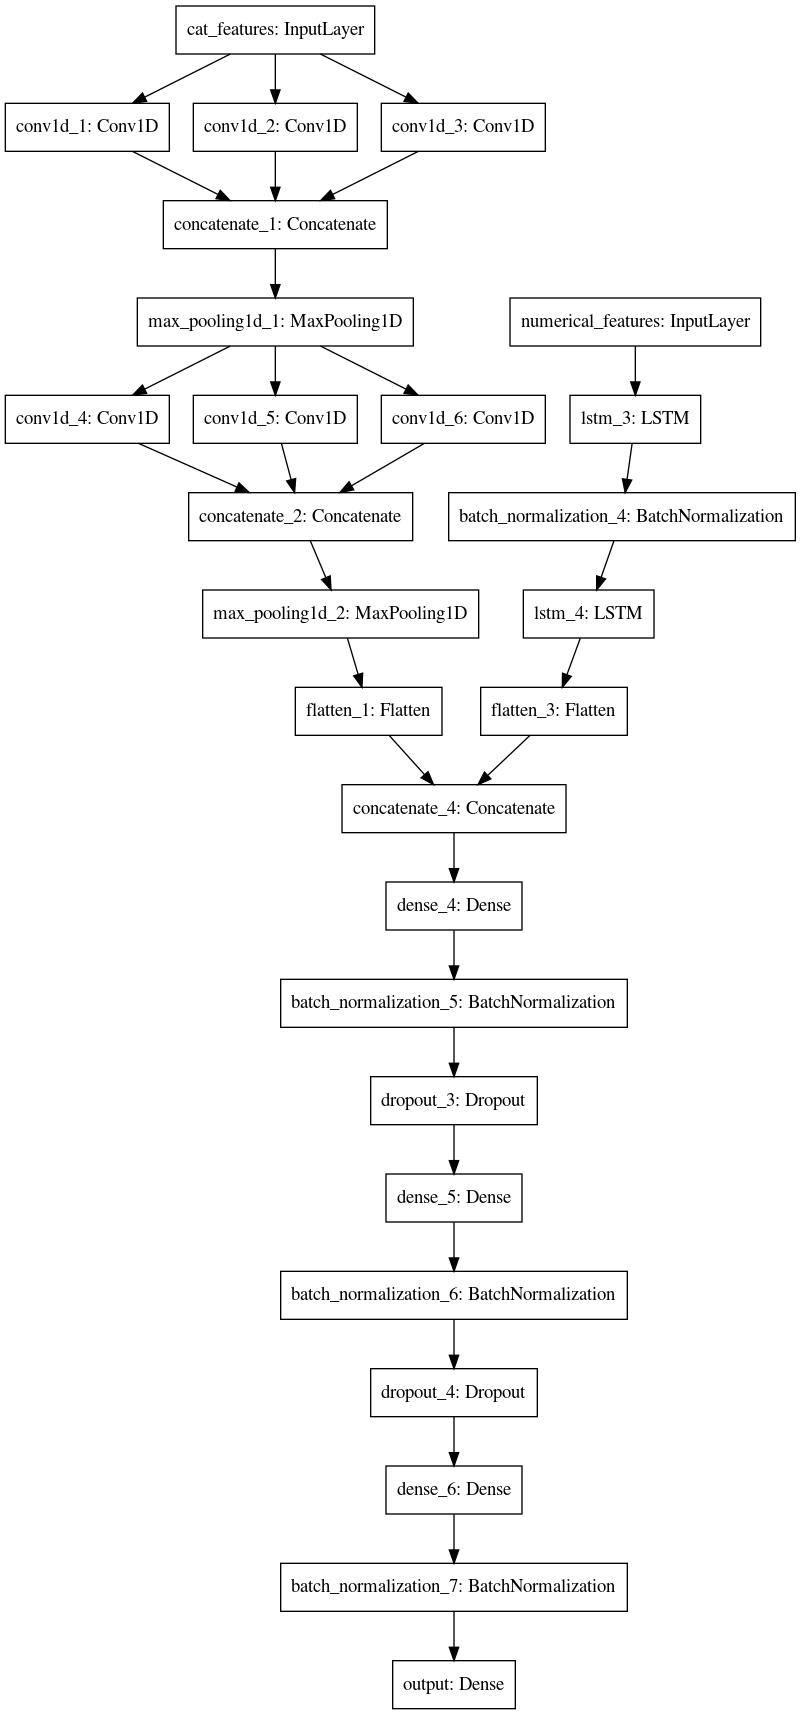

In [14]:
from tensorflow import keras
keras.utils.plot_model(model_nn, "my_first_model.png")